In [1]:
from dbConn import engine
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
base_query = '''
SELECT 
    spx.Datetime,
    spx.Open AS Open_SPX,
    spx.High AS High_SPX,
    spx.Low AS Low_SPX,
    spx.Close AS Close_SPX,
    ndx.Open AS Open_NDX,
    ndx.High AS High_NDX,
    ndx.Low AS Low_NDX,
    ndx.Close AS Close_NDX,
    rut.Open AS Open_RUT,
    rut.High AS High_RUT,
    rut.Low AS Low_RUT,
    rut.Close AS Close_RUT
    FROM (
    SELECT * FROM SPX_full_5min
    ) spx
    JOIN (
    SELECT * FROM NDX_full_5min
    ) ndx ON spx.Datetime = ndx.Datetime
    LEFT JOIN (
    SELECT * FROM RUT_full_5min
    ) rut ON spx.Datetime = rut.Datetime
-- WHERE spx.Datetime >= '2018-01-01'
'''

# Initialize variables for pagination
offset = 0
limit = 50000
data_frames = []

while True:
    # Construct the query with LIMIT and OFFSET
    query = f"{base_query} LIMIT {limit} OFFSET {offset}"
    
    # Fetch the chunk of data
    df_chunk = pd.read_sql_query(query, con = engine.connect())
    
    # Break the loop if no more data is returned
    if df_chunk.empty:
        break

    # Append the chunk to the list of dataframes
    data_frames.append(df_chunk)

    # Update the offset for the next query
    offset += limit

# Concatenate all dataframes
data = pd.concat(data_frames, ignore_index=True)

In [3]:
len(data)

334831

In [4]:
data.head()

,Datetime,Open_SPX,High_SPX,Low_SPX,Close_SPX,Open_NDX,High_NDX,Low_NDX,Close_NDX,Open_RUT,High_RUT,Low_RUT,Close_RUT
0,2007-04-27 12:20:00,1492.19,1492.40,1492.19,1492.38,1887.90,1887.91,1886.97,1887.65,829.54,829.55,829.35,829.41
1,2007-04-27 12:25:00,1492.39,1492.91,1492.39,1492.87,1887.72,1888.32,1887.72,1888.27,829.42,829.68,829.42,829.68
2,2007-04-27 12:30:00,1492.54,1492.80,1492.53,1492.58,1887.77,1888.68,1887.65,1888.13,829.65,829.84,829.65,829.73
3,2007-04-27 12:35:00,1492.70,1492.88,1492.30,1492.88,1888.09,1888.24,1887.27,1888.24,829.65,829.65,829.25,829.38
4,2007-04-27 12:40:00,1492.88,1494.46,1492.88,1493.94,1888.26,1890.01,1888.26,1889.31,829.39,830.08,829.39,830.03


In [5]:
data['Date'] = data['Datetime'].dt.date
data['Time'] = data['Datetime'].dt.time

In [6]:
data['Datetime'].min()

Timestamp('2007-04-27 12:20:00')

In [7]:
data['Datetime'].max()

Timestamp('2024-03-19 16:00:00')

In [8]:
import datetime

# Start Run Models

In [64]:
ticker_dict = {
    "^GSPC":{
        "hod_model":"models/hod_model_spx.joblib",
        "lod_model":"models/lod_model_spx.joblib",
        "gd_model":"models/gd_model_spx.joblib",
        "hod_model_cv":"models/hod_model_cv_spx.joblib",
        "lod_model_cv":"models/lod_model_cv_spx.joblib",
        "gd_model_cv":"models/gd_model_cv_spx.joblib",
        "suffix":"SPX"
    },
    "^NDX":{
        "hod_model":"models/hod_model_ndx.joblib",
        "lod_model":"models/lod_model_ndx.joblib",
        "gd_model":"models/gd_model_ndx.joblib",
        "hod_model_cv":"models/hod_model_cv_ndx.joblib",
        "lod_model_cv":"models/lod_model_cv_ndx.joblib",
        "gd_model_cv":"models/gd_model_cv_ndx.joblib",
        "suffix":"NDX"
    },
    "^RUT":{
        "hod_model":"models/hod_model_rut.joblib",
        "lod_model":"models/lod_model_rut.joblib",
        "gd_model":"models/gd_model_rut.joblib",
        "suffix":"RUT"
    }
}

tck = '^NDX'

spx_data = data.loc[:,[
    'Datetime',
    f'Open_{ticker_dict[tck]["suffix"]}',
    f'High_{ticker_dict[tck]["suffix"]}',
    f'Low_{ticker_dict[tck]["suffix"]}',
    f'Close_{ticker_dict[tck]["suffix"]}'
]]
spx_data.columns = ['Datetime','open','high','low','close']
spx_data['time'] = spx_data['Datetime'].dt.time

def categorize_time(time):
    if time < pd.Timestamp("11:30").time():
        return 1
    elif time < pd.Timestamp("13:00").time():
        return 2
    elif time < pd.Timestamp("15:00").time():
        return 3
    else:
        return 4

# Apply the categorize_time function to each time in the 'time' column to create a new 'phase' column
spx_data['phase'] = spx_data['time'].apply(categorize_time)

spx_data = spx_data.loc[(spx_data['time'] < datetime.time(16,0)) & (spx_data['time'] >= datetime.time(9,30))]

In [65]:
spx_data = spx_data.set_index('Datetime')

In [66]:
# Create a list of times from 9:30 to 15:55 with 5 minute intervals
times = pd.date_range(start="9:30", end="15:55", freq='5min').time

# Create a dictionary that maps each time to a unique integer
time_to_int = {time: i+1 for i, time in enumerate(times)}

# Assume df is your DataFrame and 'time' is your column of times
spx_data['bar_num'] = spx_data['time'].map(time_to_int)

In [67]:
# Get the last bar of each date
spx_data['eod_close'] = spx_data.groupby(spx_data.index.date)['close'].tail(1)
spx_data['prev_close'] = spx_data['eod_close'].shift(1)
spx_data['prev_close'] = spx_data['prev_close'].ffill()
spx_data['eod_close'] = spx_data['eod_close'].bfill()
spx_data['green_day'] = spx_data['eod_close'] > spx_data['prev_close']

spx_data['eod_close_pts'] = spx_data['eod_close'] - spx_data['prev_close']
spx_data['eod_close_pct'] = spx_data['eod_close_pts'] / spx_data['prev_close']

In [68]:
spx_data.head()

,open,high,low,close,time,phase,bar_num,eod_close,prev_close,green_day,eod_close_pts,eod_close_pct
Datetime,,,,,,,,,,,,
2007-04-27 12:20:00,1887.90,1887.91,1886.97,1887.65,12:20:00,2,35,1891.0,NaN,False,NaN,NaN
2007-04-27 12:25:00,1887.72,1888.32,1887.72,1888.27,12:25:00,2,36,1891.0,NaN,False,NaN,NaN
2007-04-27 12:30:00,1887.77,1888.68,1887.65,1888.13,12:30:00,2,37,1891.0,NaN,False,NaN,NaN
2007-04-27 12:35:00,1888.09,1888.24,1887.27,1888.24,12:35:00,2,38,1891.0,NaN,False,NaN,NaN
2007-04-27 12:40:00,1888.26,1890.01,1888.26,1889.31,12:40:00,2,39,1891.0,NaN,False,NaN,NaN


In [69]:
spx_data.tail()

,open,high,low,close,time,phase,bar_num,eod_close,prev_close,green_day,eod_close_pts,eod_close_pct
Datetime,,,,,,,,,,,,
2024-03-19 15:35:00,17986.28,18007.45,17985.47,18007.45,15:35:00,4,74,18031.18,17984.28,True,46.9,0.002608
2024-03-19 15:40:00,18007.41,18009.06,17999.10,18004.32,15:40:00,4,75,18031.18,17984.28,True,46.9,0.002608
2024-03-19 15:45:00,18004.46,18033.77,18004.40,18032.21,15:45:00,4,76,18031.18,17984.28,True,46.9,0.002608
2024-03-19 15:50:00,18032.89,18039.71,18023.26,18035.70,15:50:00,4,77,18031.18,17984.28,True,46.9,0.002608
2024-03-19 15:55:00,18035.18,18039.82,18023.38,18031.18,15:55:00,4,78,18031.18,17984.28,True,46.9,0.002608


# Feature and Target Creation
Target
- Whether the current high or low of the **session** has been achieved, based on the close of the most recent 5 min bar. 

Features
- Current and lagged features of each **session**.

In [70]:
import numpy as np
import pandas as pd
import datetime
from pandas.tseries.offsets import BDay
from tqdm import tqdm

spx_data['label'] = np.nan


# Per date, run it.
for day in tqdm(sorted(set(spx_data.index.date))):
    day_str = datetime.datetime.strftime(day, '%Y-%m-%d')
    day_open = spx_data.loc[day_str, 'open'].iloc[0]
    day_5m_or_upper = spx_data.loc[day_str, 'high'].iloc[0]
    day_5m_or_lower = spx_data.loc[day_str, 'low'].iloc[0]
    spx_data.loc[day_str, 'lod'] = spx_data.loc[day_str, 'low'].min()
    spx_data.loc[day_str, 'label_lod'] = (spx_data.loc[day_str, 'low'] == spx_data.loc[day_str, 'lod']).astype(int)
    
    spx_data.loc[day_str, 'hod'] = spx_data.loc[day_str, 'high'].max()
    spx_data.loc[day_str, 'label'] = (spx_data.loc[day_str, 'high'] == spx_data.loc[day_str, 'hod']).astype(int)
    spx_data.loc[day_str, 'day_open'] = day_open
    spx_data.loc[day_str, 'day_open_pts'] = spx_data.loc[day_str, 'close'] - spx_data.loc[day_str, 'day_open']
    spx_data.loc[day_str, 'day_open_pct'] = spx_data.loc[day_str, 'day_open_pts'] / spx_data.loc[day_str, 'day_open']
    spx_data.loc[day_str, 'prev_close_pts'] = spx_data.loc[day_str, 'close'] - spx_data.loc[day_str, 'prev_close']
    spx_data.loc[day_str, 'prev_close_pct'] = spx_data.loc[day_str, 'prev_close_pts'] / spx_data.loc[day_str, 'prev_close']

    # Openiing Range
    spx_data.loc[day_str, 'day_5m_or_upper'] = day_5m_or_upper
    spx_data.loc[day_str, 'day_5m_or_lower'] = day_5m_or_lower

    spx_data.loc[day_str, 'open_range_upper_pts'] = spx_data.loc[day_str, 'close'] - spx_data.loc[day_str, 'day_5m_or_upper']
    spx_data.loc[day_str, 'open_range_lower_pts'] = spx_data.loc[day_str, 'close'] - spx_data.loc[day_str, 'day_5m_or_lower']

    spx_data.loc[day_str, 'open_range_upper_pct'] = spx_data.loc[day_str, 'open_range_upper_pts'] / spx_data.loc[day_str, 'day_open']
    spx_data.loc[day_str, 'open_range_lower_pct'] = spx_data.loc[day_str, 'open_range_lower_pts'] / spx_data.loc[day_str, 'day_open']

    # Lowest low
    spx_data.loc[day_str, 'lowest_low'] = spx_data.loc[day_str, 'low'].expanding().min()
    spx_data.loc[day_str, 'lowest_low'] = spx_data.loc[day_str, 'lowest_low'].shift(1)
    spx_data.loc[day_str, 'lowest_low'] = spx_data.loc[day_str, 'lowest_low'].ffill()
    spx_data.loc[day_str, 'lowest_low_mag'] = (spx_data.loc[day_str, 'close'] / spx_data.loc[day_str, 'lowest_low']) - 1
    spx_data.loc[day_str, 'lowest_low_mag_n1'] = spx_data.loc[day_str, 'lowest_low_mag'].shift(1)
    spx_data.loc[day_str, 'lowest_low_mag_n2'] = spx_data.loc[day_str, 'lowest_low_mag'].shift(2)
    spx_data.loc[day_str, 'lowest_low_mag_n3'] = spx_data.loc[day_str, 'lowest_low_mag'].shift(3)

    # Highest high
    spx_data.loc[day_str, 'highest_high'] = spx_data.loc[day_str, 'high'].expanding().max()
    spx_data.loc[day_str, 'highest_high'] = spx_data.loc[day_str, 'highest_high'].shift(1)
    spx_data.loc[day_str, 'highest_high'] = spx_data.loc[day_str, 'highest_high'].ffill()
    spx_data.loc[day_str, 'highest_high_mag'] = (spx_data.loc[day_str, 'close'] / spx_data.loc[day_str, 'highest_high']) - 1
    spx_data.loc[day_str, 'highest_high_mag_n1'] = spx_data.loc[day_str, 'highest_high_mag'].shift(1)
    spx_data.loc[day_str, 'highest_high_mag_n2'] = spx_data.loc[day_str, 'highest_high_mag'].shift(2)
    spx_data.loc[day_str, 'highest_high_mag_n3'] = spx_data.loc[day_str, 'highest_high_mag'].shift(3)

    # Shifted
    spx_data.loc[day_str, 'prev_close_pct_n1'] = spx_data.loc[day_str, 'prev_close_pct'].shift(1)
    spx_data.loc[day_str, 'prev_close_pct_n2'] = spx_data.loc[day_str, 'prev_close_pct'].shift(2)
    spx_data.loc[day_str, 'prev_close_pct_n3'] = spx_data.loc[day_str, 'prev_close_pct'].shift(3)

    spx_data.loc[day_str, 'day_open_pct_n1'] = spx_data.loc[day_str, 'day_open_pct'].shift(1)
    spx_data.loc[day_str, 'day_open_pct_n2'] = spx_data.loc[day_str, 'day_open_pct'].shift(2)
    spx_data.loc[day_str, 'day_open_pct_n3'] = spx_data.loc[day_str, 'day_open_pct'].shift(3)

    # New Features
    spx_data.loc[day_str, 'open_slope'] = spx_data.loc[day_str, 'day_open_pct'] / spx_data.loc[day_str, 'bar_num']
    spx_data.loc[day_str, 'daily_slope'] = spx_data.loc[day_str, 'prev_close_pct'] / spx_data.loc[day_str, 'bar_num']
    spx_data.loc[day_str, 'highest_high_slope'] = (spx_data.loc[day_str, 'close'] - spx_data.loc[day_str, 'highest_high']) / spx_data.loc[day_str, 'bar_num']
    spx_data.loc[day_str, 'lowest_low_slope'] = (spx_data.loc[day_str, 'close'] - spx_data.loc[day_str, 'lowest_low']) / spx_data.loc[day_str, 'bar_num']
    # spx_data.loc[day_str, 'day_range_pct'] = (spx_data.loc[day_str, ['highest_high','prev_close']].max(axis=1) - spx_data.loc[day_str, ['lowest_low','prev_close']].min(axis=1)) / spx_data.loc[day_str, 'prev_close']
    # spx_data.loc[day_str, 'day_range_pct_n1'] = spx_data.loc[day_str, 'day_range_pct'].shift(1)
    # spx_data.loc[day_str, 'day_range_pct_n2'] = spx_data.loc[day_str, 'day_range_pct'].shift(2)
    # spx_data.loc[day_str, 'day_range_pct_n3'] = spx_data.loc[day_str, 'day_range_pct'].shift(3)

    # Label the data: 1 if the current high is the HOD, 0 otherwise

    # # Find the index of HOD
    # hod_index = spx_data.loc[day_str][spx_data.loc[day_str, 'label'] == 1].index

    # # If HOD is found within the first 5 bars, label the first 5 bars as 1
    # if not hod_index.empty:
    #     hod_index = hod_index[0]  # In case there are multiple, take the first
    #     if hod_index <= spx_data.loc[day_str].index[4]:  # Check if HOD is within the first 5 bars
    #         spx_data.loc[spx_data.loc[day_str].index[:5], 'label'] = 1
    #     else:
    #         start_time = spx_data.loc[day_str].index[0]
    #         end_time = hod_index
    #         # Calculate the start index using Timedelta
    #         start_index = end_time - pd.Timedelta(minutes=5 * 4)
    #         start_index = max(start_index, start_time)
    #         spx_data.loc[start_index:end_time, 'label'] = 1

# spx_data.head()


  0%|          | 0/4252 [00:00<?, ?it/s]

100%|██████████| 4252/4252 [03:02<00:00, 23.28it/s]


In [71]:
spx_data['gap_open'] = spx_data['day_open'] - spx_data['prev_close']
spx_data['gap_open_pct'] = spx_data['gap_open'] / spx_data['prev_close']

In [72]:
spx_data.isnull().sum()

open                        0
high                        0
low                         0
close                       0
time                        0
phase                       0
bar_num                     0
eod_close                   0
prev_close                 44
green_day                   0
eod_close_pts              44
eod_close_pct              44
label                       0
lod                         0
label_lod                   0
hod                         0
day_open                    0
day_open_pts                0
day_open_pct                0
prev_close_pts             44
prev_close_pct             44
day_5m_or_upper             0
day_5m_or_lower             0
open_range_upper_pts        0
open_range_lower_pts        0
open_range_upper_pct        0
open_range_lower_pct        0
lowest_low               4252
lowest_low_mag           4252
lowest_low_mag_n1        8504
lowest_low_mag_n2       12756
lowest_low_mag_n3       17008
highest_high             4252
highest_hi

In [73]:
hod_in = []
for num, row in tqdm(spx_data.iterrows()):
    if row['hod'] == row['high']:
        hod_in.append(1)
    else:
        hod_in.append(np.nan)
spx_data['hod_in'] = hod_in

330544it [00:09, 33467.45it/s]


In [74]:
lod_in = []
for num, row in tqdm(spx_data.iterrows()):
    if row['lod'] == row['low']:
        lod_in.append(1)
    else:
        lod_in.append(np.nan)
spx_data['lod_in'] = lod_in

330544it [00:09, 33651.86it/s]


In [75]:
# Per day, ffill for the 1s, and then fillna 0
for day in tqdm(sorted(set(spx_data.index.date))):
    day_str = datetime.datetime.strftime(day, '%Y-%m-%d')
    spx_data.loc[day_str, 'lod_in'] = spx_data.loc[day_str, 'lod_in'].ffill()
    spx_data.loc[day_str, 'lod_in'] = spx_data.loc[day_str, 'lod_in'].fillna(0)
    spx_data.loc[day_str, 'hod_in'] = spx_data.loc[day_str, 'hod_in'].ffill()
    spx_data.loc[day_str, 'hod_in'] = spx_data.loc[day_str, 'hod_in'].fillna(0)

100%|██████████| 4252/4252 [00:15<00:00, 279.71it/s]


# EDA

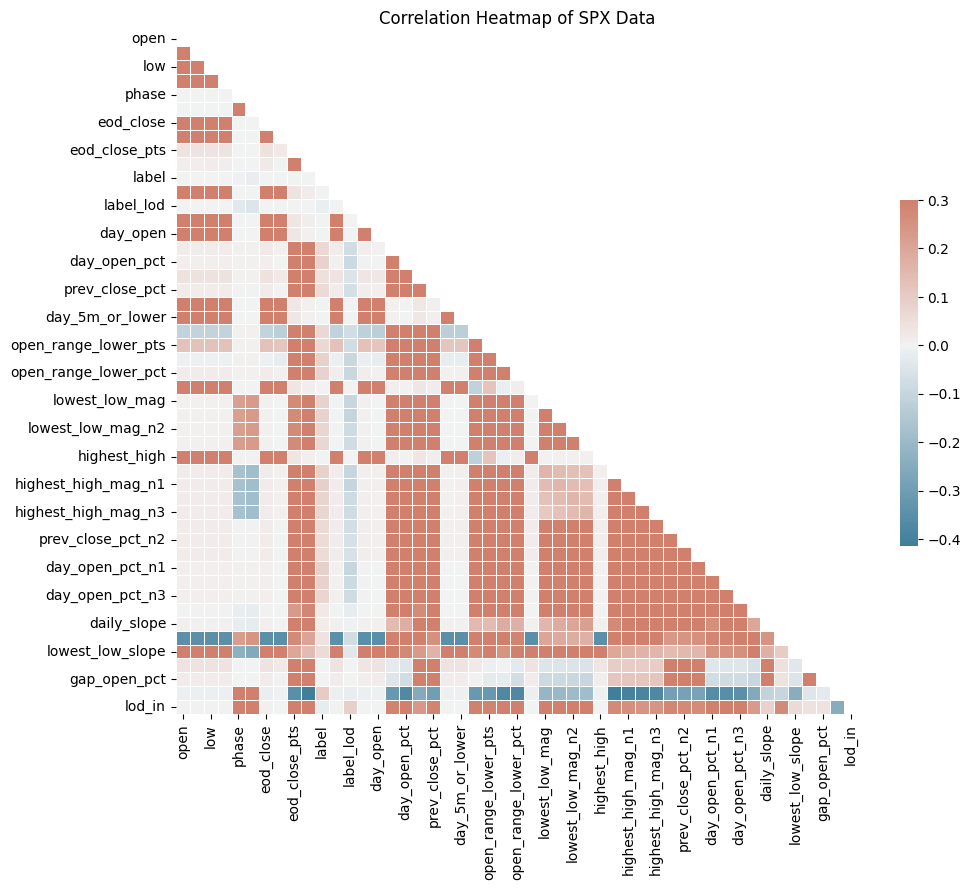

In [76]:
# Correlations with HOD
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix

num_cols = spx_data.select_dtypes(include='number').columns

corr = spx_data[num_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap of SPX Data')
plt.show()


count    330500.000000
mean          0.000342
std           0.008242
min          -0.084446
25%          -0.003150
50%           0.000682
75%           0.004204
max           0.058855
Name: gap_open_pct, dtype: float64


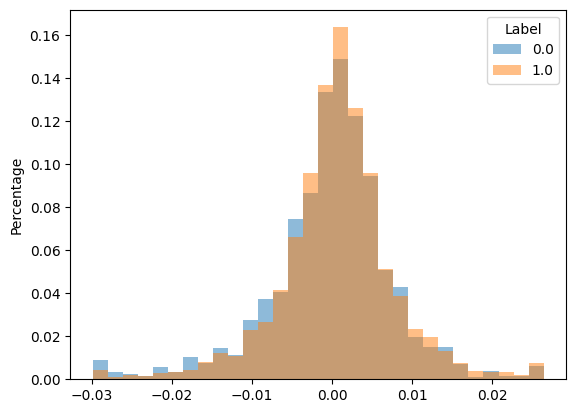

In [77]:
import matplotlib.pyplot as plt

col = 'gap_open_pct'
u = spx_data[col].quantile(0.005)
l = spx_data[col].quantile(0.995)
print(spx_data[col].describe())
datav = spx_data[col].clip(lower=u, upper=l)

# Group the data
grouped = datav.groupby(spx_data['lod_in'])

# Create a new figure
plt.figure()

# Loop over the groups and plot each one
for name, group in grouped:
    # Calculate weights for each data point
    weights = np.ones_like(group)/float(len(group))

    # Plot the histogram with weights
    plt.hist(group, weights=weights, bins=30, alpha=0.5, label=str(name))

# Set y-axis label
plt.ylabel('Percentage')

# Add a legend
plt.legend(title='Label')

# Show the plot
plt.show()

In [78]:
def get_top_probability(time, prev_close_pct):
    '''
    Function that returns the historical probability that the top is in, given a time of day and magnitude.
    '''
    # Filter the data for the given time and magnitude
    relevant_data = spx_data[(spx_data['time'] == time) & (spx_data['prev_close_pct'] >= prev_close_pct)]
    
    # Calculate the probability
    top_probability = relevant_data['hod_in'].mean()
    # bot_probability = relevant_data['lod_in'].mean()
    
    return top_probability

def get_low_probability(time, prev_close_pct):
    '''
    Function that returns the historical probability that the low is in, given a time of day and magnitude.
    '''
    # Filter the data for the given time and magnitude
    relevant_data = spx_data[(spx_data['time'] == time) & (spx_data['prev_close_pct'] <= prev_close_pct)]
    
    # Calculate the probability
    probability = relevant_data['lod_in'].mean()
    
    return probability

In [79]:
time = datetime.time(15,0)
prev_close_pct = -0.007
# spx_data.loc[(spx_data['time'] == time) & (spx_data['prev_close_pct'] >= prev_close_pct)]
get_top_probability(time, prev_close_pct)

0.6738095238095239

In [80]:
get_low_probability(time, prev_close_pct)

0.5286549707602339

In [81]:
spx_data[['time','hod_in','lod_in','gap_open_pct','open']]

,time,hod_in,lod_in,gap_open_pct,open
Datetime,,,,,
2007-04-27 12:20:00,12:20:00,0.0,0.0,NaN,1887.90
2007-04-27 12:25:00,12:25:00,0.0,0.0,NaN,1887.72
2007-04-27 12:30:00,12:30:00,0.0,0.0,NaN,1887.77
2007-04-27 12:35:00,12:35:00,0.0,0.0,NaN,1888.09
2007-04-27 12:40:00,12:40:00,0.0,0.0,NaN,1888.26
...,...,...,...,...,...
2024-03-19 15:35:00,15:35:00,0.0,1.0,-0.004546,17986.28
2024-03-19 15:40:00,15:40:00,0.0,1.0,-0.004546,18007.41
2024-03-19 15:45:00,15:45:00,0.0,1.0,-0.004546,18004.46


In [82]:
spx_data.columns

Index(['open', 'high', 'low', 'close', 'time', 'phase', 'bar_num', 'eod_close',
       'prev_close', 'green_day', 'eod_close_pts', 'eod_close_pct', 'label',
       'lod', 'label_lod', 'hod', 'day_open', 'day_open_pts', 'day_open_pct',
       'prev_close_pts', 'prev_close_pct', 'day_5m_or_upper',
       'day_5m_or_lower', 'open_range_upper_pts', 'open_range_lower_pts',
       'open_range_upper_pct', 'open_range_lower_pct', 'lowest_low',
       'lowest_low_mag', 'lowest_low_mag_n1', 'lowest_low_mag_n2',
       'lowest_low_mag_n3', 'highest_high', 'highest_high_mag',
       'highest_high_mag_n1', 'highest_high_mag_n2', 'highest_high_mag_n3',
       'prev_close_pct_n1', 'prev_close_pct_n2', 'prev_close_pct_n3',
       'day_open_pct_n1', 'day_open_pct_n2', 'day_open_pct_n3', 'open_slope',
       'daily_slope', 'highest_high_slope', 'lowest_low_slope', 'gap_open',
       'gap_open_pct', 'hod_in', 'lod_in'],
      dtype='object')

# Pipeline

In [83]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.preprocessing import FunctionTransformer, StandardScaler
import datetime

# Function to convert time string to seconds past midnight
def convert_time_to_seconds(time_series):
    return time_series.apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

def apply_convert_time_to_seconds(x):
    return x.apply(convert_time_to_seconds)

time_to_seconds = FunctionTransformer(apply_convert_time_to_seconds, validate=False)

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('time', make_pipeline(time_to_seconds, StandardScaler()), ['time']),
        ('phase', StandardScaler(), ['phase']),
        ('prev_close_pct', StandardScaler(), ['prev_close_pct']),
        ('prev_close_pct_n1', StandardScaler(), ['prev_close_pct_n1']),
        ('prev_close_pct_n2', StandardScaler(), ['prev_close_pct_n2']),
        ('prev_close_pct_n3', StandardScaler(), ['prev_close_pct_n3']),
        ('day_open_pct', StandardScaler(), ['day_open_pct']),
        ('day_open_pct_n1', StandardScaler(), ['day_open_pct_n1']),
        ('day_open_pct_n2', StandardScaler(), ['day_open_pct_n2']),
        ('day_open_pct_n3', StandardScaler(), ['day_open_pct_n3']),
        ('gap_open_pct', StandardScaler(), ['gap_open_pct']),
        ('highest_high_mag', StandardScaler(), ['highest_high_mag']),
        # ('highest_high_mag_n1', StandardScaler(), ['highest_high_mag_n1']),
        # ('highest_high_mag_n2', StandardScaler(), ['highest_high_mag_n2']),
        # ('highest_high_mag_n3', StandardScaler(), ['highest_high_mag_n3']),
        ('lowest_low_mag', StandardScaler(), ['lowest_low_mag']),
        # ('lowest_low_mag_n1', StandardScaler(), ['lowest_low_mag_n1']),
        # ('lowest_low_mag_n2', StandardScaler(), ['lowest_low_mag_n2']),
        # ('lowest_low_mag_n3', StandardScaler(), ['lowest_low_mag_n3']),
        ('open_slope', StandardScaler(), ['open_slope']),
        ('daily_slope', StandardScaler(), ['daily_slope']),
        ('highest_high_slope', StandardScaler(), ['highest_high_slope']),
        ('lowest_low_slope', StandardScaler(), ['lowest_low_slope']),
        ('open_range_upper_pct', StandardScaler(), ['open_range_upper_pct']),
        ('open_range_lower_pct', StandardScaler(), ['open_range_lower_pct']),
        # ('day_range_pct', StandardScaler(), ['day_range_pct']),
        # ('day_range_pct_n1', StandardScaler(), ['day_range_pct_n1']),
        # ('day_range_pct_n2', StandardScaler(), ['day_range_pct_n2']),
        # ('day_range_pct_n3', StandardScaler(), ['day_range_pct_n3']),
    ])

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('classifier', LogisticRegression())
    ('classifier', lgb.LGBMClassifier())
    # ('classifier', CatBoostClassifier())
    # ('classifier', xgb.XGBClassifier())
])

df_use = spx_data.dropna(subset=[
    'prev_close_pct',
    'gap_open_pct',
    'day_open_pct_n3',
    'prev_close_pct_n3'
    ])

# Train the model
X = df_use[[
    'time',
    'phase',
    'prev_close_pct',
    'prev_close_pct_n1',
    'prev_close_pct_n2',
    'prev_close_pct_n3',
    'day_open_pct',
    'day_open_pct_n1',
    'day_open_pct_n2',
    'day_open_pct_n3',
    'gap_open_pct',
    'highest_high_mag',
    # 'highest_high_mag_n1',
    # 'highest_high_mag_n2',
    # 'highest_high_mag_n3',
    'lowest_low_mag',
    # 'lowest_low_mag_n1',
    # 'lowest_low_mag_n2',
    # 'lowest_low_mag_n3',
    'open_slope',
    'daily_slope',
    'highest_high_slope',
    'lowest_low_slope',
    'open_range_upper_pct',
    'open_range_lower_pct',
    # 'day_range_pct',
    # 'day_range_pct_n1',
    # 'day_range_pct_n2',
    # 'day_range_pct_n3'
]]
y_flags = df_use[['lod_in','hod_in','green_day']]
# pipeline.fit(X, y)

In [84]:
X['time'].min()

datetime.time(9, 45)

In [85]:
from sklearn.base import clone

pipeline_lod = clone(pipeline)
pipeline_gd = clone(pipeline)

# Data Splits

In [86]:

date_idx = int(np.floor(len(X.index.date) * .90))
date_idx_test = int(np.floor(len(X.index.date) * .95))
cutoff_date_val = X.index.date[date_idx]
cutoff_date_test = X.index.date[date_idx_test]
# cutoff_date = '2023-05-31'

X_train = X.loc[:cutoff_date_test]
y_train = y_flags.loc[:cutoff_date_test]
# X_val = X.loc[cutoff_date_val:cutoff_date_test]
# y_val = y_flags.loc[cutoff_date_val:cutoff_date_test]
X_test = X.loc[cutoff_date_test:]
y_test = y_flags.loc[cutoff_date_test:]

In [87]:
print(cutoff_date_test)

2023-05-15


In [88]:
len(y_train)

301833

In [89]:
len(y_test)

15914

In [90]:
y_train.mean()

lod_in       0.645148
hod_in       0.563285
green_day    0.552869
dtype: float64

In [91]:
y_test.mean()

lod_in       0.641134
hod_in       0.578296
green_day    0.573017
dtype: float64

In [92]:
X.isnull().sum()

time                    0
phase                   0
prev_close_pct          0
prev_close_pct_n1       0
prev_close_pct_n2       0
prev_close_pct_n3       0
day_open_pct            0
day_open_pct_n1         0
day_open_pct_n2         0
day_open_pct_n3         0
gap_open_pct            0
highest_high_mag        0
lowest_low_mag          0
open_slope              0
daily_slope             0
highest_high_slope      0
lowest_low_slope        0
open_range_upper_pct    0
open_range_lower_pct    0
dtype: int64

In [93]:
X.dtypes

time                     object
phase                     int64
prev_close_pct          float64
prev_close_pct_n1       float64
prev_close_pct_n2       float64
prev_close_pct_n3       float64
day_open_pct            float64
day_open_pct_n1         float64
day_open_pct_n2         float64
day_open_pct_n3         float64
gap_open_pct            float64
highest_high_mag        float64
lowest_low_mag          float64
open_slope              float64
daily_slope             float64
highest_high_slope      float64
lowest_low_slope        float64
open_range_upper_pct    float64
open_range_lower_pct    float64
dtype: object

In [94]:
import joblib
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import TimeSeriesSplit

hod_model = pipeline.fit(X_train, y_train['hod_in'])
lod_model = pipeline_lod.fit(X_train, y_train['lod_in'])
gd_model = pipeline_gd.fit(X_train, y_train['green_day'])

calibrator_hod = CalibratedClassifierCV(hod_model, cv=TimeSeriesSplit(n_splits=5))
calibrator_lod = CalibratedClassifierCV(lod_model, cv=TimeSeriesSplit(n_splits=5))
calibrator_gd = CalibratedClassifierCV(gd_model, cv=TimeSeriesSplit(n_splits=5))

hod_model_cv = calibrator_hod.fit(X_train, y_train['hod_in'])
lod_model_cv = calibrator_lod.fit(X_train, y_train['lod_in'])
gd_model_cv = calibrator_gd.fit(X_train, y_train['green_day'])

# Save models
joblib.dump(hod_model, ticker_dict[tck]["hod_model"])
joblib.dump(lod_model, ticker_dict[tck]["lod_model"])
joblib.dump(gd_model, ticker_dict[tck]["gd_model"])

joblib.dump(hod_model_cv, ticker_dict[tck]["hod_model_cv"])
joblib.dump(lod_model_cv, ticker_dict[tck]["lod_model_cv"])
joblib.dump(gd_model_cv, ticker_dict[tck]["gd_model_cv"])

[LightGBM] [Info] Number of positive: 170018, number of negative: 131815
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4416
[LightGBM] [Info] Number of data points in the train set: 301833, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.563285 -> initscore=0.254505
[LightGBM] [Info] Start training from score 0.254505
[LightGBM] [Info] Number of positive: 194727, number of negative: 107106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4416
[LightGBM] [Info] Number of data points in the train set: 301833, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.645148 -> initscore=0.597780

['models/gd_model_cv_ndx.joblib']

# Performance

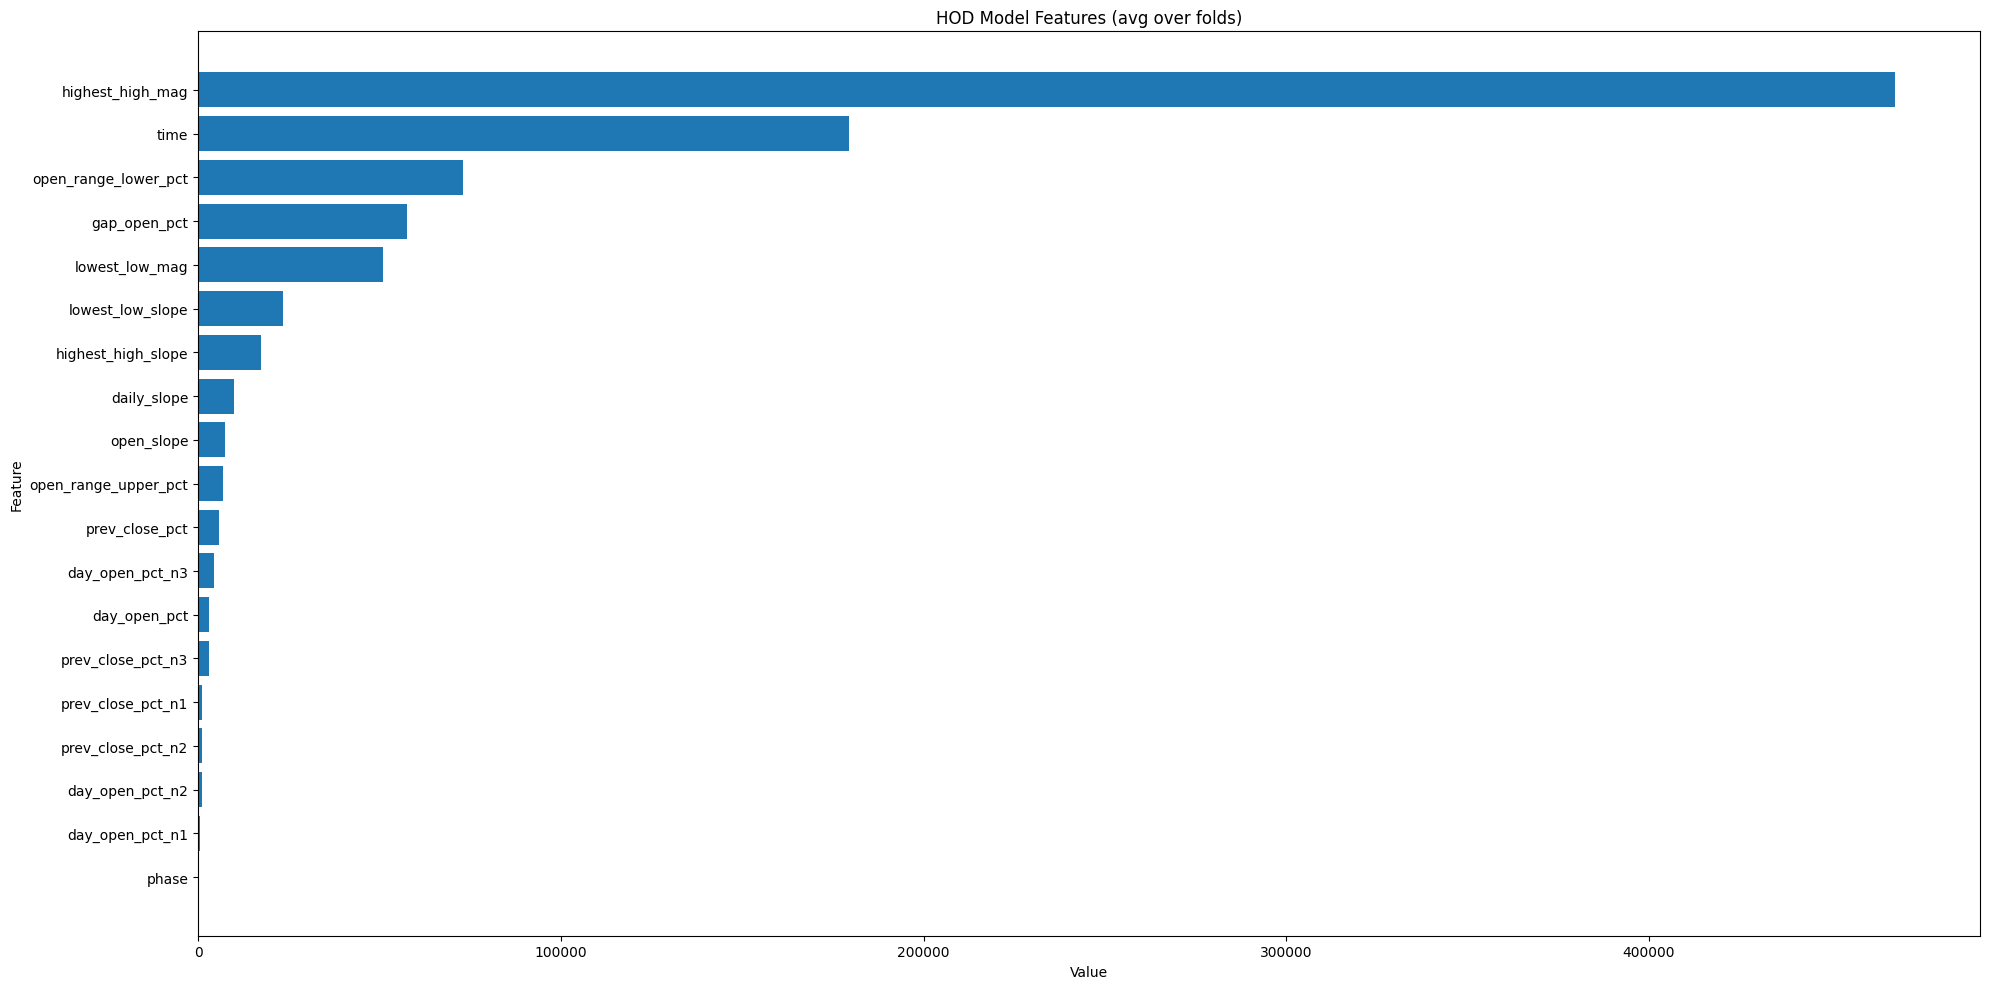

In [95]:
import mlflow
import matplotlib.pyplot as plt

booster = hod_model.named_steps['classifier'].booster_
importance_gain = booster.feature_importance(importance_type='gain')
feature_imp = pd.DataFrame(sorted(zip(importance_gain, X.columns)), columns=['Value','Feature'])
feature_imp = feature_imp.sort_values(by="Value", ascending=True)

plt.figure(figsize=(20, 10))
plt.barh(feature_imp['Feature'], feature_imp['Value'])
plt.title('HOD Model Features (avg over folds)')
plt.xlabel('Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


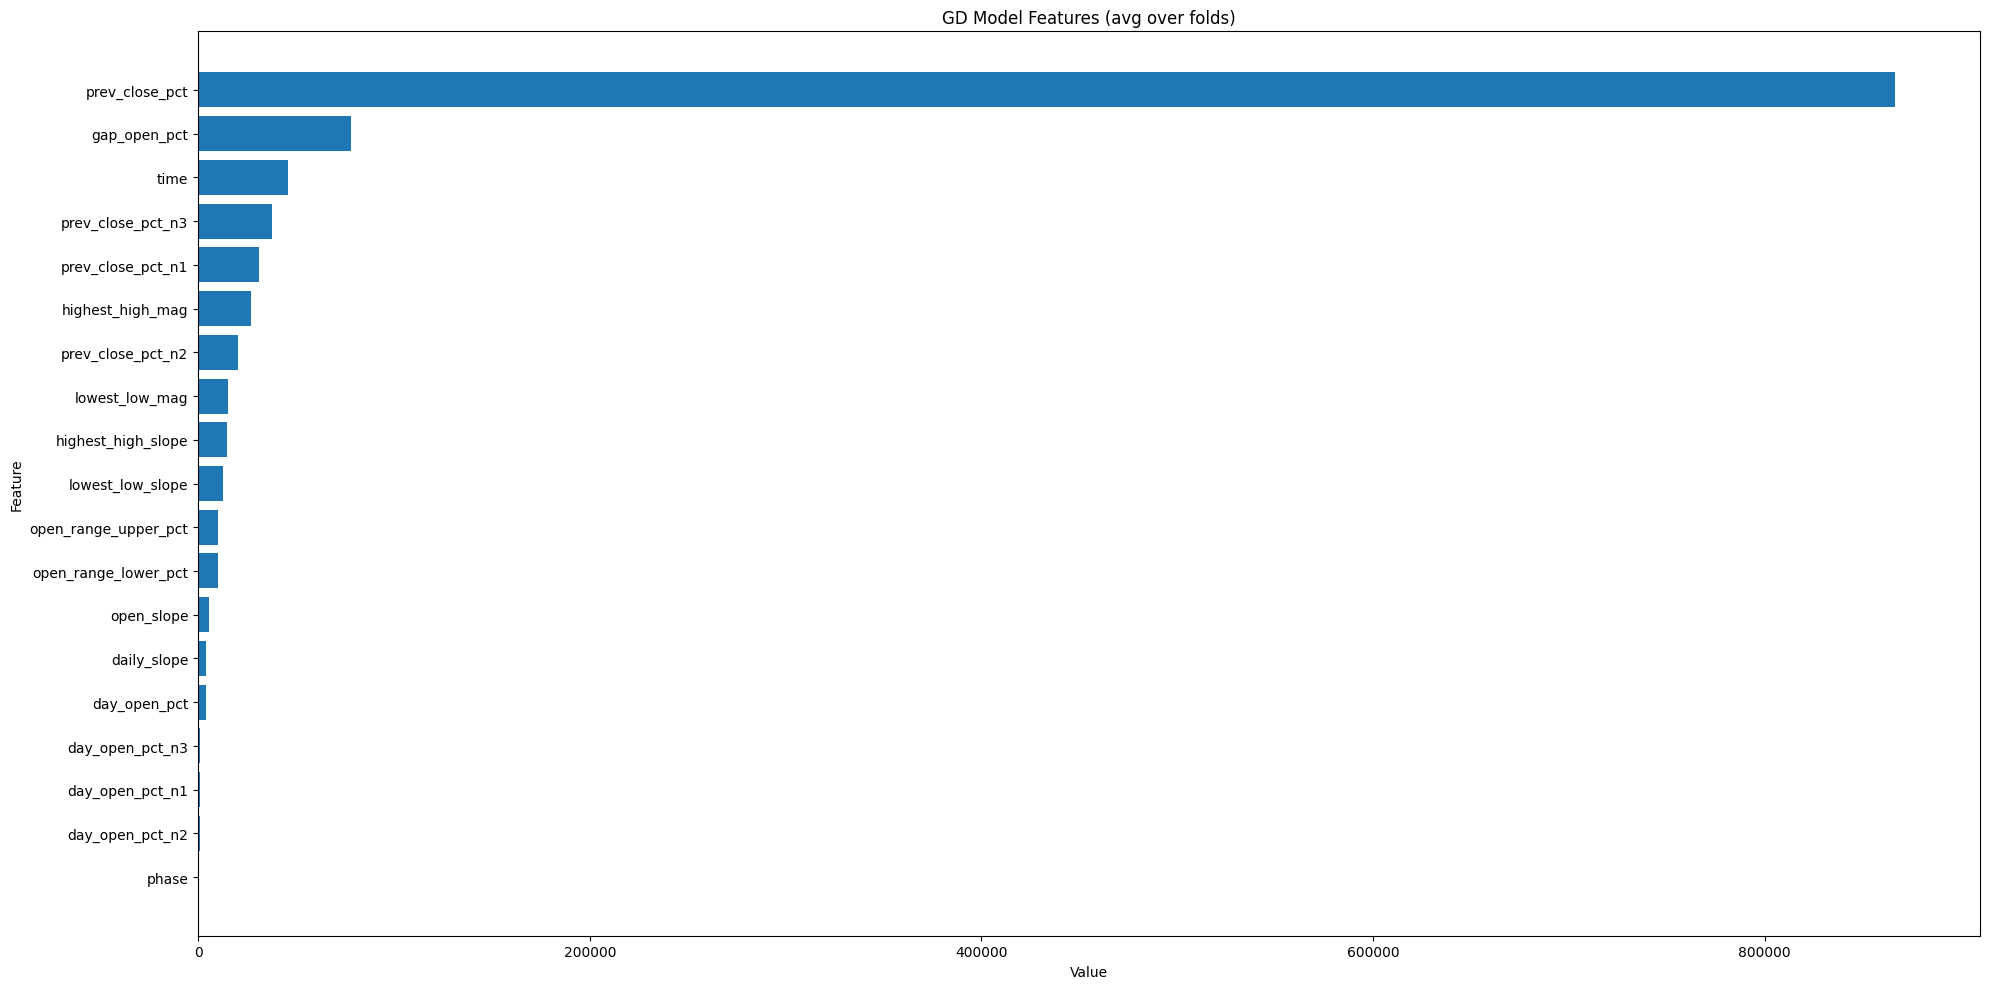

In [96]:
booster = gd_model.named_steps['classifier'].booster_
importance_gain = booster.feature_importance(importance_type='gain')
feature_imp = pd.DataFrame(sorted(zip(importance_gain, X.columns)), columns=['Value','Feature'])
feature_imp = feature_imp.sort_values(by="Value", ascending=True)

plt.figure(figsize=(20, 10))
plt.barh(feature_imp['Feature'], feature_imp['Value'])
plt.title('GD Model Features (avg over folds)')
plt.xlabel('Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


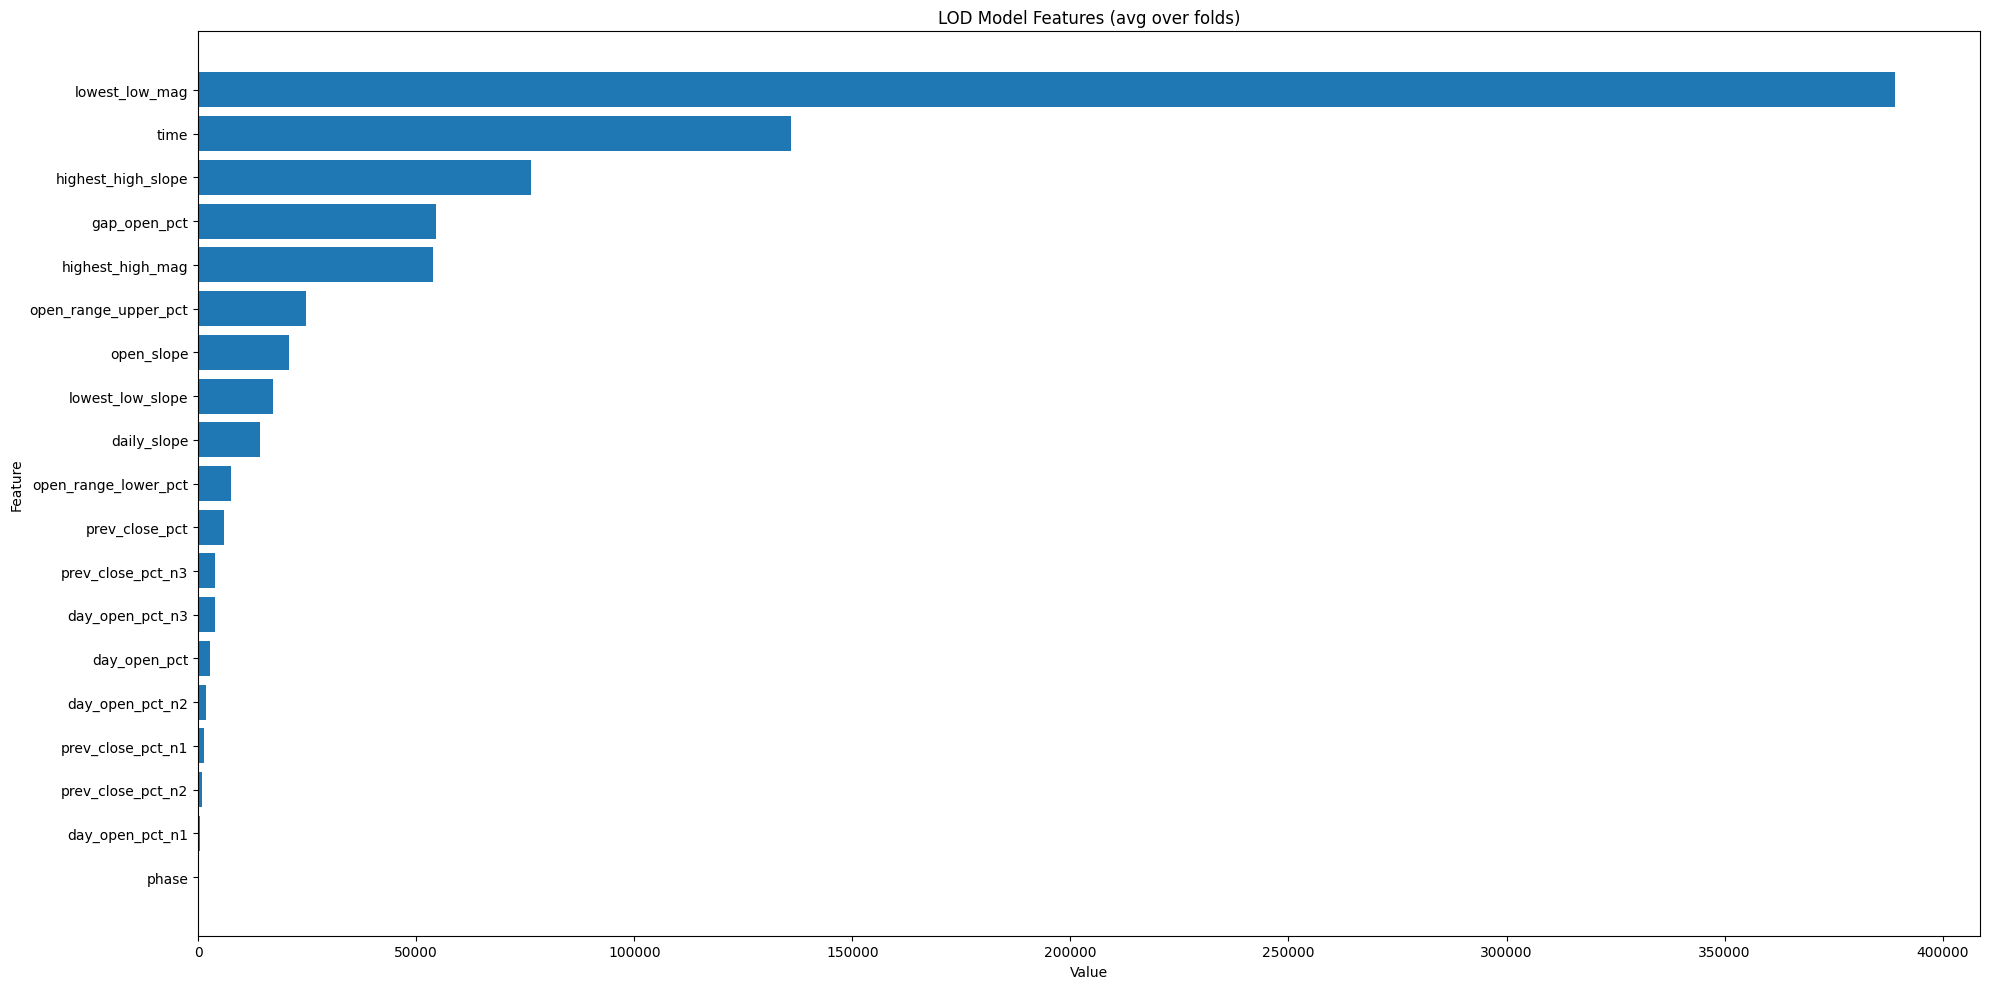

In [97]:
booster = lod_model.named_steps['classifier'].booster_
importance_gain = booster.feature_importance(importance_type='gain')
feature_imp = pd.DataFrame(sorted(zip(importance_gain, X.columns)), columns=['Value','Feature'])
feature_imp = feature_imp.sort_values(by="Value", ascending=True)

plt.figure(figsize=(20, 10))
plt.barh(feature_imp['Feature'], feature_imp['Value'])
plt.title('LOD Model Features (avg over folds)')
plt.xlabel('Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


### Train/Test

In [98]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, brier_score_loss
import mlflow

# Metrics for HOD model
y_pred_hod = hod_model.predict_proba(X_test)[:,-1]

roc_auc_hod = roc_auc_score(y_test['hod_in'], y_pred_hod)
precision_hod = precision_score(y_test['hod_in'], y_pred_hod > 0.5)
recall_hod = recall_score(y_test['hod_in'], y_pred_hod > 0.5)
brier_score_hod = brier_score_loss(y_test['hod_in'], y_pred_hod)

print(f"ROC AUC Score: {roc_auc_hod}")
print(f"Precision Score: {precision_hod}")
print(f"Recall Score: {recall_hod}")
print(f"Brier Score: {brier_score_hod}")

train_start = X_train.index.date.min()
train_end = X_train.index.date.max()
test_start = X_test.index.date.min()
test_end = X_test.index.date.max()
train_size = len(X_train)
test_size = len(X_test)

# Start a new MLFlow run
with mlflow.start_run():

    ts = datetime.datetime.now()

    mlflow.set_tag(f"mlflow.runName", f"{tck} HOD Model {ts.hour:02}:{ts.minute:02}:{ts.second:02}")

    # Log the model
    mlflow.log_param("model", str(hod_model.named_steps))

    # Log the features
    mlflow.log_param("features", hod_model.feature_names_in_)
    mlflow.log_param("train_date_range", f"{train_start} to {train_end}")
    mlflow.log_param("test_date_range", f"{test_start} to {test_end}")
    mlflow.log_param("train_size", train_size)
    mlflow.log_param("test_size", test_size)

    # Assume y_test and y_pred are your test labels and model predictions
    # Calculate scores

    # Log the scores
    mlflow.log_metric("roc_auc", roc_auc_hod)
    mlflow.log_metric("precision", precision_hod)
    mlflow.log_metric("recall", recall_hod)
    mlflow.log_metric("brier_score", brier_score_hod)

    # Log the timestamp
    mlflow.log_param("created_at", ts)

print('done.')

ROC AUC Score: 0.8874468350610243
Precision Score: 0.8586879011171856
Recall Score: 0.7850700858415735
Brier Score: 0.1367829109985802
done.


In [99]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import mlflow

# Metrics for HOD model
y_pred_lod = lod_model.predict_proba(X_test)[:,-1]
roc_auc_lod = roc_auc_score(y_test['lod_in'], y_pred_lod)
precision_lod = precision_score(y_test['lod_in'], y_pred_lod > 0.5)
recall_lod = recall_score(y_test['lod_in'], y_pred_lod > 0.5)
brier_score_lod = brier_score_loss(y_test['lod_in'], y_pred_lod)


print(f"ROC AUC Score: {roc_auc_lod}")
print(f"Precision Score: {precision_lod}")
print(f"Recall Score: {recall_lod}")
print(f"Brier Score: {brier_score_lod}")

train_start = X_train.index.date.min()
train_end = X_train.index.date.max()
test_start = X_test.index.date.min()
test_end = X_test.index.date.max()
train_size = len(X_train)
test_size = len(X_test)

# Start a new MLFlow run
with mlflow.start_run():

    ts = datetime.datetime.now()

    mlflow.set_tag(f"mlflow.runName", f"{tck} LOD Model {ts.hour:02}:{ts.minute:02}:{ts.second:02}")

    # Log the model
    mlflow.log_param("model", str(lod_model.named_steps))

    # Log the features
    mlflow.log_param("features", lod_model.feature_names_in_)
    mlflow.log_param("train_date_range", f"{train_start} to {train_end}")
    mlflow.log_param("test_date_range", f"{test_start} to {test_end}")
    mlflow.log_param("train_size", train_size)
    mlflow.log_param("test_size", test_size)

    # Assume y_test and y_pred are your test labels and model predictions
    # Calculate scores

    # Log the scores
    mlflow.log_metric("roc_auc", roc_auc_lod)
    mlflow.log_metric("precision", precision_lod)
    mlflow.log_metric("recall", recall_lod)
    mlflow.log_metric("brier_score", brier_score_lod)


    # Log the timestamp
    mlflow.log_param("created_at", ts)

print('done.')

ROC AUC Score: 0.8700150128713503
Precision Score: 0.8275796661608498
Recall Score: 0.8552386552974616
Brier Score: 0.14023419516679653
done.


In [100]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import mlflow

# Metrics for HOD model
y_pred_gd = gd_model.predict_proba(X_test)[:,-1]

roc_auc_gd = roc_auc_score(y_test['green_day'], y_pred_gd)
precision_gd = precision_score(y_test['green_day'], y_pred_gd > 0.5)
recall_gd = recall_score(y_test['green_day'], y_pred_gd > 0.5)
brier_score_gd = brier_score_loss(y_test['green_day'], y_pred_gd)

print(f"ROC AUC Score: {roc_auc_gd}")
print(f"Precision Score: {precision_gd}")
print(f"Recall Score: {recall_gd}")
print(f"Brier Score: {brier_score_gd}")

train_start = X_train.index.date.min()
train_end = X_train.index.date.max()
test_start = X_test.index.date.min()
test_end = X_test.index.date.max()
train_size = len(X_train)
test_size = len(X_test)

# Start a new MLFlow run
with mlflow.start_run():

    ts = datetime.datetime.now()

    mlflow.set_tag(f"mlflow.runName", f"{tck} GD Model {ts.hour:02}:{ts.minute:02}:{ts.second:02}")

    # Log the model
    mlflow.log_param("model", str(gd_model.named_steps))

    # Log the features
    mlflow.log_param("features", gd_model.feature_names_in_)
    mlflow.log_param("train_date_range", f"{train_start} to {train_end}")
    mlflow.log_param("test_date_range", f"{test_start} to {test_end}")
    mlflow.log_param("train_size", train_size)
    mlflow.log_param("test_size", test_size)

    # Assume y_test and y_pred are your test labels and model predictions
    # Calculate scores

    # Log the scores
    mlflow.log_metric("roc_auc", roc_auc_gd)
    mlflow.log_metric("precision", precision_gd)
    mlflow.log_metric("recall", recall_gd)
    mlflow.log_metric("brier_score", brier_score_gd)

    # Log the timestamp
    mlflow.log_param("created_at", ts)

print('done.')

ROC AUC Score: 0.934056677302749
Precision Score: 0.8580266331131383
Recall Score: 0.8973571663559601
Brier Score: 0.10129198784586864
done.


### CV

In [101]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, brier_score_loss
import mlflow

# Metrics for HOD model
y_pred_hod_cv = hod_model_cv.predict_proba(X_test)[:,-1]

roc_auc_hod = roc_auc_score(y_test['hod_in'], y_pred_hod_cv)
precision_hod = precision_score(y_test['hod_in'], y_pred_hod_cv > 0.5)
recall_hod = recall_score(y_test['hod_in'], y_pred_hod_cv > 0.5)
brier_score_hod = brier_score_loss(y_test['hod_in'], y_pred_hod_cv)

print(f"ROC AUC Score: {roc_auc_hod}")
print(f"Precision Score: {precision_hod}")
print(f"Recall Score: {recall_hod}")
print(f"Brier Score: {brier_score_hod}")

train_start = X_train.index.date.min()
train_end = X_train.index.date.max()
test_start = X_test.index.date.min()
test_end = X_test.index.date.max()
train_size = len(X_train)
test_size = len(X_test)

# Start a new MLFlow run
with mlflow.start_run():

    ts = datetime.datetime.now()

    mlflow.set_tag(f"mlflow.runName", f"{tck} HOD Model CV {ts.hour:02}:{ts.minute:02}:{ts.second:02}")

    # Log the model
    mlflow.log_param("model", str(hod_model.named_steps))

    # Log the features
    mlflow.log_param("features", hod_model.feature_names_in_)
    mlflow.log_param("train_date_range", f"{train_start} to {train_end}")
    mlflow.log_param("test_date_range", f"{test_start} to {test_end}")
    mlflow.log_param("train_size", train_size)
    mlflow.log_param("test_size", test_size)

    # Assume y_test and y_pred are your test labels and model predictions
    # Calculate scores

    # Log the scores
    mlflow.log_metric("roc_auc", roc_auc_hod)
    mlflow.log_metric("precision", precision_hod)
    mlflow.log_metric("recall", recall_hod)
    mlflow.log_metric("brier_score", brier_score_hod)

    # Log the timestamp
    mlflow.log_param("created_at", ts)

print('done.')

ROC AUC Score: 0.8878734693112922
Precision Score: 0.8297917778964229
Recall Score: 0.8443985656851026
Brier Score: 0.13513633254543803
done.


In [102]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import mlflow

# Metrics for HOD model
y_pred_lod_cv = lod_model_cv.predict_proba(X_test)[:,-1]
roc_auc_lod = roc_auc_score(y_test['lod_in'], y_pred_lod_cv)
precision_lod = precision_score(y_test['lod_in'], y_pred_lod_cv > 0.5)
recall_lod = recall_score(y_test['lod_in'], y_pred_lod_cv > 0.5)
brier_score_lod = brier_score_loss(y_test['lod_in'], y_pred_lod_cv)


print(f"ROC AUC Score: {roc_auc_lod}")
print(f"Precision Score: {precision_lod}")
print(f"Recall Score: {recall_lod}")
print(f"Brier Score: {brier_score_lod}")

train_start = X_train.index.date.min()
train_end = X_train.index.date.max()
test_start = X_test.index.date.min()
test_end = X_test.index.date.max()
train_size = len(X_train)
test_size = len(X_test)

# Start a new MLFlow run
with mlflow.start_run():

    ts = datetime.datetime.now()

    mlflow.set_tag(f"mlflow.runName", f"{tck} LOD Model CV {ts.hour:02}:{ts.minute:02}:{ts.second:02}")

    # Log the model
    mlflow.log_param("model", str(lod_model.named_steps))

    # Log the features
    mlflow.log_param("features", lod_model.feature_names_in_)
    mlflow.log_param("train_date_range", f"{train_start} to {train_end}")
    mlflow.log_param("test_date_range", f"{test_start} to {test_end}")
    mlflow.log_param("train_size", train_size)
    mlflow.log_param("test_size", test_size)

    # Assume y_test and y_pred are your test labels and model predictions
    # Calculate scores

    # Log the scores
    mlflow.log_metric("roc_auc", roc_auc_lod)
    mlflow.log_metric("precision", precision_lod)
    mlflow.log_metric("recall", recall_lod)
    mlflow.log_metric("brier_score", brier_score_lod)


    # Log the timestamp
    mlflow.log_param("created_at", ts)

print('done.')

ROC AUC Score: 0.8673969204349739
Precision Score: 0.811377245508982
Recall Score: 0.8765069097324316
Brier Score: 0.1427001683136164
done.


In [103]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import mlflow

# Metrics for HOD model
y_pred_gd_cv = gd_model_cv.predict_proba(X_test)[:,-1]

roc_auc_gd = roc_auc_score(y_test['green_day'], y_pred_gd_cv)
precision_gd = precision_score(y_test['green_day'], y_pred_gd_cv > 0.5)
recall_gd = recall_score(y_test['green_day'], y_pred_gd_cv > 0.5)
brier_score_gd = brier_score_loss(y_test['green_day'], y_pred_gd_cv)

print(f"ROC AUC Score: {roc_auc_gd}")
print(f"Precision Score: {precision_gd}")
print(f"Recall Score: {recall_gd}")
print(f"Brier Score: {brier_score_gd}")

train_start = X_train.index.date.min()
train_end = X_train.index.date.max()
test_start = X_test.index.date.min()
test_end = X_test.index.date.max()
train_size = len(X_train)
test_size = len(X_test)

# Start a new MLFlow run
with mlflow.start_run():

    ts = datetime.datetime.now()

    mlflow.set_tag(f"mlflow.runName", f"{tck} GD Model CV {ts.hour:02}:{ts.minute:02}:{ts.second:02}")

    # Log the model
    mlflow.log_param("model", str(gd_model.named_steps))

    # Log the features
    mlflow.log_param("features", gd_model.feature_names_in_)
    mlflow.log_param("train_date_range", f"{train_start} to {train_end}")
    mlflow.log_param("test_date_range", f"{test_start} to {test_end}")
    mlflow.log_param("train_size", train_size)
    mlflow.log_param("test_size", test_size)

    # Assume y_test and y_pred are your test labels and model predictions
    # Calculate scores

    # Log the scores
    mlflow.log_metric("roc_auc", roc_auc_gd)
    mlflow.log_metric("precision", precision_gd)
    mlflow.log_metric("recall", recall_gd)
    mlflow.log_metric("brier_score", brier_score_gd)

    # Log the timestamp
    mlflow.log_param("created_at", ts)

print('done.')

ROC AUC Score: 0.9248486914213593
Precision Score: 0.8488491574188245
Recall Score: 0.9059107358262968
Brier Score: 0.10872517956697896
done.


In [104]:
%%script false --no-raise-error
from sklearn.metrics import roc_auc_score, precision_score, recall_score

# Initialize lists to store scores for each split
roc_auc_scores = []
precision_scores = []
recall_scores = []

with mlflow.start_run():

    # Loop over the splits
    for train_index, test_index in tscv.split(dates):
        # Find the end of the last complete day in the test set
        last_day = np.unique(dates[test_index])[-2]  # -2 to get the second to last day
        test_index = test_index[dates[test_index] <= last_day]  # only keep days in test set up to the last complete day

        # Split the data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_flags.iloc[train_index], y_flags.iloc[test_index]

        # Fit the model on the training data
        model = pipeline_gd.fit(X_train, y_train['green_day'])

        # Predict the test data
        y_pred = model.predict_proba(X_test)[:,-1]

        # Calculate the scores
        roc_auc = roc_auc_score(y_test['green_day'], y_pred)
        precision = precision_score(y_test['green_day'], y_pred > 0.5)
        recall = recall_score(y_test['green_day'], y_pred > 0.5)

        # Store the scores
        roc_auc_scores.append(roc_auc)
        precision_scores.append(precision)
        recall_scores.append(recall)


    roc_auc_gd = np.mean(roc_auc_scores)
    precision_gd = np.mean(precision_scores)
    recall_gd = np.mean(recall_scores)

    # Print the average scores
    print(f"Average ROC AUC Score: {roc_auc_hod:.03} (+/- {np.std(roc_auc_scores):.02})")
    print(f"Average Precision Score: {precision_hod:.03} (+/- {np.std(precision_scores):.02})")
    print(f"Average Recall Score: {recall_hod:.03} (+/- {np.std(recall_scores):.02})")

    ts = datetime.datetime.now()

    mlflow.set_tag(f"mlflow.runName", f"{tck} GD Model CV {ts.hour:02}:{ts.minute:02}:{ts.second:02}")

    # Log the model
    mlflow.log_param("model", str(gd_model.named_steps))

    # Log the features
    mlflow.log_param("features", gd_model.feature_names_in_)
    mlflow.log_param("train_date_range", f"{train_start} to {train_end}")
    mlflow.log_param("test_date_range", f"{test_start} to {test_end}")
    mlflow.log_param("train_size", train_size)
    mlflow.log_param("test_size", test_size)

    # Assume y_test and y_pred are your test labels and model predictions
    # Calculate scores

    # Log the scores
    mlflow.log_metric("roc_auc", roc_auc_gd)
    mlflow.log_metric("precision", precision_gd)
    mlflow.log_metric("recall", recall_gd)

    # Log the timestamp
    mlflow.log_param("created_at", ts)

print('done.')

Couldn't find program: 'false'


In [105]:
import datetime
import plotly.express as px


time_range = [datetime.time(hour, minute) for hour in range(9, 16) for minute in range(0, 60, 5)]
time_range = [x for x in time_range if x >= datetime.time(9,45)]
df_val = pd.DataFrame()
for t in time_range:
    X_val = X_test.loc[X_test['time'] <= t].copy()
    y_val = y_test.loc[X_val.index, 'hod_in'].copy()

    y_pred_val = pipeline.predict_proba(X_val)[:,-1]

    df_val.loc[t, [
        'roc_auc',
        'precision',
        'recall'
    ]] =  roc_auc_score(y_val, y_pred_val), precision_score(y_val, y_pred_val > 0.5), recall_score(y_val, y_pred_val > 0.5)


fig = px.line(df_val, title='Validation Metrics Over Time (HOD Model)')
fig.show()

In [106]:
import datetime
import plotly.express as px


time_range = [datetime.time(hour, minute) for hour in range(9, 16) for minute in range(0, 60, 5)]
time_range = [x for x in time_range if x >= datetime.time(9,45)]
df_val = pd.DataFrame()
for t in time_range:
    X_val = X_test.loc[X_test['time'] <= t].copy()
    y_val = y_test.loc[X_val.index, 'hod_in'].copy()

    y_pred_val = pipeline.predict_proba(X_val)[:,-1]

    df_val.loc[t, [
        'roc_auc',
        'precision',
        'recall'
    ]] =  roc_auc_score(y_val, y_pred_val), precision_score(y_val, y_pred_val > 0.5), recall_score(y_val, y_pred_val > 0.5)


fig = px.line(df_val, title='Validation Metrics Over Time (HOD Model)')
fig.show()

In [107]:
import datetime
import plotly.express as px


time_range = [datetime.time(hour, minute) for hour in range(9, 16) for minute in range(0, 60, 5)]
time_range = [x for x in time_range if x >= datetime.time(9,45)]
df_val = pd.DataFrame()
for t in time_range:
    X_val = X_test.loc[X_test['time'] <= t].copy()
    y_val = y_test.loc[X_val.index, 'hod_in'].copy()

    y_pred_val = hod_model_cv.predict_proba(X_val)[:,-1]

    df_val.loc[t, [
        'roc_auc',
        'precision',
        'recall'
    ]] =  roc_auc_score(y_val, y_pred_val), precision_score(y_val, y_pred_val > 0.5), recall_score(y_val, y_pred_val > 0.5)


fig = px.line(df_val, title='Validation Metrics Over Time (HOD Model CV)')
fig.show()

In [108]:
import datetime
import plotly.express as px

time_range = [datetime.time(hour, minute) for hour in range(9, 16) for minute in range(0, 60, 5)]
time_range = [x for x in time_range if x >= datetime.time(9,45)]
df_val = pd.DataFrame()
for t in time_range:
    X_val = X_test.loc[X_test['time'] <= t].copy()
    y_val = y_test.loc[X_val.index, 'lod_in'].copy()

    y_pred_val = pipeline_lod.predict_proba(X_val)[:,-1]

    df_val.loc[t, [
        'roc_auc',
        'precision',
        'recall'
    ]] =  roc_auc_score(y_val, y_pred_val), precision_score(y_val, y_pred_val > 0.5), recall_score(y_val, y_pred_val > 0.5)


fig = px.line(df_val, title='Validation Metrics Over Time (LOD Model)')
fig.show()

In [109]:
import datetime
import plotly.express as px

time_range = [datetime.time(hour, minute) for hour in range(9, 16) for minute in range(0, 60, 5)]
time_range = [x for x in time_range if x >= datetime.time(9,45)]
df_val = pd.DataFrame()
for t in time_range:
    X_val = X_test.loc[X_test['time'] <= t].copy()
    y_val = y_test.loc[X_val.index, 'lod_in'].copy()

    y_pred_val = lod_model_cv.predict_proba(X_val)[:,-1]

    df_val.loc[t, [
        'roc_auc',
        'precision',
        'recall'
    ]] =  roc_auc_score(y_val, y_pred_val), precision_score(y_val, y_pred_val > 0.5), recall_score(y_val, y_pred_val > 0.5)


fig = px.line(df_val, title='Validation Metrics Over Time (LOD Model CV)')
fig.show()

In [110]:
import datetime
import plotly.express as px

time_range = [datetime.time(hour, minute) for hour in range(9, 16) for minute in range(0, 60, 5)]
time_range = [x for x in time_range if x >= datetime.time(9,45)]
df_val = pd.DataFrame()
for t in time_range:
    X_val = X_test.loc[X_test['time'] <= t].copy()
    y_val = y_test.loc[X_val.index, 'green_day'].copy()

    y_pred_val = pipeline_gd.predict_proba(X_val)[:,-1]

    df_val.loc[t, [
        'roc_auc',
        'precision',
        'recall'
    ]] =  roc_auc_score(y_val, y_pred_val), precision_score(y_val, y_pred_val > 0.5), recall_score(y_val, y_pred_val > 0.5)


fig = px.line(df_val, title='Validation Metrics Over Time (GD Model)')
fig.show()

In [111]:
import datetime
import plotly.express as px

time_range = [datetime.time(hour, minute) for hour in range(9, 16) for minute in range(0, 60, 5)]
time_range = [x for x in time_range if x >= datetime.time(9,45)]
df_val = pd.DataFrame()
for t in time_range:
    X_val = X_test.loc[X_test['time'] <= t].copy()
    y_val = y_test.loc[X_val.index, 'green_day'].copy()

    y_pred_val = gd_model_cv.predict_proba(X_val)[:,-1]

    df_val.loc[t, [
        'roc_auc',
        'precision',
        'recall'
    ]] =  roc_auc_score(y_val, y_pred_val), precision_score(y_val, y_pred_val > 0.5), recall_score(y_val, y_pred_val > 0.5)


fig = px.line(df_val, title='Validation Metrics Over Time (GD Model CV)')
fig.show()

In [112]:
df_results = X_test.copy()
df_results['pred_hod'] = y_pred_hod
df_results['pred_lod'] = y_pred_lod
df_results['pred_gd'] = y_pred_gd

df_results['pred_hod_cv'] = y_pred_hod_cv
df_results['pred_lod_cv'] = y_pred_lod_cv
df_results['pred_gd_cv'] = y_pred_gd_cv

df_results['actual_hod'] = y_flags['hod_in']
df_results['actual_lod'] = y_flags['lod_in']
df_results['actual_gd'] = y_flags['green_day']

In [113]:
df_results.columns

Index(['time', 'phase', 'prev_close_pct', 'prev_close_pct_n1',
       'prev_close_pct_n2', 'prev_close_pct_n3', 'day_open_pct',
       'day_open_pct_n1', 'day_open_pct_n2', 'day_open_pct_n3', 'gap_open_pct',
       'highest_high_mag', 'lowest_low_mag', 'open_slope', 'daily_slope',
       'highest_high_slope', 'lowest_low_slope', 'open_range_upper_pct',
       'open_range_lower_pct', 'pred_hod', 'pred_lod', 'pred_gd',
       'pred_hod_cv', 'pred_lod_cv', 'pred_gd_cv', 'actual_hod', 'actual_lod',
       'actual_gd'],
      dtype='object')

In [114]:
df_results.loc[:,['pred_hod','actual_hod']]

,pred_hod,actual_hod
Datetime,,
2023-05-15 09:45:00,0.225122,0.0
2023-05-15 09:50:00,0.514667,0.0
2023-05-15 09:55:00,0.563937,0.0
2023-05-15 10:00:00,0.454434,0.0
2023-05-15 10:05:00,0.664678,0.0
...,...,...
2024-03-19 15:35:00,0.570391,0.0
2024-03-19 15:40:00,0.716020,0.0
2024-03-19 15:45:00,0.278039,0.0


In [115]:
X_test.index[0]

Timestamp('2023-05-15 09:45:00')

In [116]:
import plotly.graph_objects as go

# Pick a day in the test set
test_day = '2023-12-27'
# test_day = '2024-01-03'
test_df = df_results.loc[test_day:test_day]
X_prices = spx_data.loc[test_day:test_day, ['open','high','low','close']]

df_viz = test_df.merge(X_prices, left_index=True, right_index=True)

fig = go.Figure(data=[go.Candlestick(x=df_viz.index,
                open=df_viz['open'],
                high=df_viz['high'],
                low=df_viz['low'],
                close=df_viz['close'])])

# fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz['pred_hod'].ewm(2).mean(), mode='lines', name='pred_hod', yaxis='y2', line=dict(color='#ff5f5f')))
fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz['pred_hod'], mode='lines', name='pred_hod', yaxis='y2', line=dict(color='#ff5f5f')))
fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz['pred_lod'], mode='lines', name='pred_lod', yaxis='y2', line=dict(color='#3399cc')))
fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz['pred_gd'], mode='lines', name='pred_lod', yaxis='y2', line=dict(color='#98ff98')))

fig.add_shape(
    type="line",
    x0=df_viz.index.min(),
    x1=df_viz.index.max(),
    y0=0.5,
    y1=0.5,
    yref='y2',
    line=dict(
        color="Red",
        width=1.5,
        dash="dash",
    )
)

fig.update_layout(
    template='plotly_dark',
    yaxis=dict(
        tickformat='.0f'
    ),
    yaxis2=dict(
        overlaying='y',
        side='right',
        tickformat=".0%"
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    title='OHLC vs Prediction Over Time',
    xaxis_rangeslider_visible=False
)

fig.show()

In [117]:
test_df = df_results.loc[test_day:test_day]
X_prices = spx_data.loc[test_day:test_day, ['open','high','low','close']]

df_viz = test_df.merge(X_prices, left_index=True, right_index=True)

fig = go.Figure(data=[go.Candlestick(x=df_viz.index,
                open=df_viz['open'],
                high=df_viz['high'],
                low=df_viz['low'],
                close=df_viz['close'])])

# fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz['pred_hod'].ewm(2).mean(), mode='lines', name='pred_hod', yaxis='y2', line=dict(color='#ff5f5f')))
fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz['pred_hod_cv'], mode='lines', name='pred_hod', yaxis='y2', line=dict(color='#ff5f5f')))
fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz['pred_lod_cv'], mode='lines', name='pred_lod', yaxis='y2', line=dict(color='#3399cc')))
fig.add_trace(go.Scatter(x=df_viz.index, y=df_viz['pred_gd_cv'], mode='lines', name='pred_lod', yaxis='y2', line=dict(color='#98ff98')))

fig.add_shape(
    type="line",
    x0=df_viz.index.min(),
    x1=df_viz.index.max(),
    y0=0.5,
    y1=0.5,
    yref='y2',
    line=dict(
        color="Red",
        width=1.5,
        dash="dash",
    )
)

fig.update_layout(
    template='plotly_dark',
    yaxis=dict(
        tickformat='.0f'
    ),
    yaxis2=dict(
        overlaying='y',
        side='right',
        tickformat=".0%"
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    title='OHLC vs Prediction Over Time',
    xaxis_rangeslider_visible=False
)

fig.show()

In [118]:
XXX

NameError: name 'XXX' is not defined

# Inference Pipeline

In [ ]:
# Get data
import yfinance as yf
import numpy as np
import pandas as pd
import datetime

# Create a list of times from 9:30 to 15:55 with 5 minute intervals
times = pd.date_range(start="9:30", end="15:55", freq='5min').time

# Create a dictionary that maps each time to a unique integer
time_to_int = {time: i+1 for i, time in enumerate(times)}


def create_features(ticker_str):
    '''
    Function to create dataframe of features for top/bottom model.
    '''
    ticker = yf.Ticker(ticker_str)
    df = ticker.history(period='5d',interval='5m')
    df = df.loc[
        (df.index.time >= datetime.time(9,30)) &\
        (df.index.time < datetime.time(16,0)),
    ['Open','High','Low','Close']]
    df.columns = ['open','high','low','close']

    df['time'] = df.index.time
    df['eod_close'] = df.groupby(df.index.date)['close'].tail(1)
    df['prev_close'] = df['eod_close'].shift(1)
    df['prev_close'] = df['prev_close'].ffill()
    df['eod_close'] = df['eod_close'].bfill()
    df['green_day'] = df['eod_close'] > df['prev_close']

    # Assume df is your DataFrame and 'time' is your column of times
    df['bar_num'] = df['time'].map(time_to_int)

    df['eod_close_pts'] = df['eod_close'] - df['prev_close']
    df['eod_close_pct'] = df['eod_close_pts'] / df['prev_close']

    for day in sorted(set(df.index.date)):
        day_str = datetime.datetime.strftime(day, '%Y-%m-%d')
        day_open = df.loc[day_str, 'open'].iloc[0]
        df.loc[day_str, 'lod'] = df.loc[day_str, 'low'].min()
        df.loc[day_str, 'label_lod'] = (df.loc[day_str, 'low'] == df.loc[day_str, 'lod']).astype(int)
        
        df.loc[day_str, 'hod'] = df.loc[day_str, 'high'].max()
        df.loc[day_str, 'label'] = (df.loc[day_str, 'high'] == df.loc[day_str, 'hod']).astype(int)
        df.loc[day_str, 'day_open'] = day_open
        df.loc[day_str, 'day_open_pts'] = df.loc[day_str, 'close'] - df.loc[day_str, 'day_open']
        df.loc[day_str, 'day_open_pct'] = df.loc[day_str, 'day_open_pts'] / df.loc[day_str, 'day_open']
        df.loc[day_str, 'prev_close_pts'] = df.loc[day_str, 'close'] - df.loc[day_str, 'prev_close']
        df.loc[day_str, 'prev_close_pct'] = df.loc[day_str, 'prev_close_pts'] / df.loc[day_str, 'prev_close']

        # Lowest low
        df.loc[day_str, 'lowest_low'] = df.loc[day_str, 'low'].expanding().min()
        df.loc[day_str, 'lowest_low'] = df.loc[day_str, 'lowest_low'].shift(1)
        df.loc[day_str, 'lowest_low'] = df.loc[day_str, 'lowest_low'].ffill()
        df.loc[day_str, 'lowest_low_mag'] = (df.loc[day_str, 'close'] / df.loc[day_str, 'lowest_low']) - 1

        # Highest high
        df.loc[day_str, 'highest_high'] = df.loc[day_str, 'high'].expanding().max()
        df.loc[day_str, 'highest_high'] = df.loc[day_str, 'highest_high'].shift(1)
        df.loc[day_str, 'highest_high'] = df.loc[day_str, 'highest_high'].ffill()
        df.loc[day_str, 'highest_high_mag'] = (df.loc[day_str, 'close'] / df.loc[day_str, 'highest_high']) - 1

        # Shifted
        df.loc[day_str, 'prev_close_pct_n1'] = df.loc[day_str, 'prev_close_pct'].shift(1)
        df.loc[day_str, 'prev_close_pct_n2'] = df.loc[day_str, 'prev_close_pct'].shift(2)
        df.loc[day_str, 'prev_close_pct_n3'] = df.loc[day_str, 'prev_close_pct'].shift(3)

        df.loc[day_str, 'day_open_pct_n1'] = df.loc[day_str, 'day_open_pct'].shift(1)
        df.loc[day_str, 'day_open_pct_n2'] = df.loc[day_str, 'day_open_pct'].shift(2)
        df.loc[day_str, 'day_open_pct_n3'] = df.loc[day_str, 'day_open_pct'].shift(3)

        # New Features
        df.loc[day_str, 'open_slope'] = df.loc[day_str, 'day_open_pct'] / df.loc[day_str, 'bar_num']
        df.loc[day_str, 'daily_slope'] = df.loc[day_str, 'prev_close_pct'] / df.loc[day_str, 'bar_num']

        df.loc[day_str, 'highest_high_slope'] = (df.loc[day_str, 'close'] - df.loc[day_str, 'highest_high']) / df.loc[day_str, 'bar_num']
        df.loc[day_str, 'lowest_low_slope'] = (df.loc[day_str, 'close'] - df.loc[day_str, 'lowest_low']) / df.loc[day_str, 'bar_num']
    
        
    df['gap_open'] = df['day_open'] - df['prev_close']
    df['gap_open_pct'] = df['gap_open'] / df['prev_close']
    df = df.dropna(subset=[
        'prev_close_pct',
        'gap_open_pct',
        'day_open_pct_n3',
        'prev_close_pct_n3'
    ])
    df = df.loc[(df['time'] < datetime.time(16,0)) & (df['time'] >= datetime.time(9,45))]
    return df

In [ ]:
import joblib

df_feats = create_features(tck)

In [ ]:

hod_model1 = joblib.load(ticker_dict[tck]['hod_model'])
lod_model1 = joblib.load(ticker_dict[tck]['lod_model'])
gd_model1 = joblib.load(ticker_dict[tck]['gd_model'])

def create_preds_df(df_feats):
    predicted_proba_hod = hod_model1.predict_proba(df_feats)[:,-1]
    predicted_proba_lod = lod_model1.predict_proba(df_feats)[:,-1]
    predicted_proba_gd = gd_model1.predict_proba(df_feats)[:,-1]
    df_viz = df_feats.copy()
    df_viz['pred_hod'] = predicted_proba_hod
    df_viz['pred_lod'] = predicted_proba_lod
    df_viz['pred_gd'] = predicted_proba_gd
    return df_viz

df_viz = create_preds_df(df_feats)

In [ ]:
# Create df for visual
def create_viz(df_viz, date_str):

    df_use = df_viz.loc[date_str:date_str]
    
    fig = go.Figure(data=[go.Candlestick(x=df_use.index,
                open=df_use['open'],
                high=df_use['high'],
                low=df_use['low'],
                close=df_use['close'])])

    fig.add_trace(go.Scatter(x=df_use.index, y=df_use['pred_hod'], mode='lines', name='pred_hod', yaxis='y2', line=dict(color='#ff5f5f')))
    fig.add_trace(go.Scatter(x=df_use.index, y=df_use['pred_lod'], mode='lines', name='pred_lod', yaxis='y2', line=dict(color='#3399cc')))
    fig.add_trace(go.Scatter(x=df_use.index, y=df_use['pred_gd'], mode='lines', name='pred_gd', yaxis='y2', line=dict(color='#9400d3')))


    fig.add_shape(
        type="line",
        x0=df_use.index.min(),
        x1=df_use.index.max(),
        y0=0.5,
        y1=0.5,
        yref='y2',
        line=dict(
            color="Red",
            width=1.5,
            dash="dash",
        )
    )

    max_high = df_use['high'].max()
    max_high_time = df_use['high'].idxmax()

    min_low = df_use['low'].min()
    min_low_time = df_use['low'].idxmin()

    fig.add_annotation(
        x=max_high_time,
        y=max_high,
        text=f"{str(int(max_high))}",
        showarrow=True,
        font=dict(
            family="Courier New, monospace",
            size=12,
            color="#ffffff"
        ),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=20,
        ay=-30,
        bordercolor="#c7c7c7",
        borderwidth=1,
        borderpad=1,
        bgcolor="#ff5f5f",
        opacity=0.8
    )

    fig.add_annotation(
        x=min_low_time,
        y=min_low,
        text=f"{str(int(min_low))}",
        showarrow=True,
        font=dict(
            family="Courier New, monospace",
            size=12,
            color="#ffffff"
        ),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=20,
        ay=30,  # Adjust the y offset for the annotation
        bordercolor="#c7c7c7",
        borderwidth=1,
        borderpad=1,
        bgcolor="#3399cc",
        opacity=0.8
    )

    fig.update_layout(
        template='plotly_dark',
        yaxis=dict(
            tickformat='.0f'
        ),
        yaxis2=dict(
            overlaying='y',
            side='right',
            tickformat=".0%"
        ),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        title='OHLC vs Prediction Over Time',
        xaxis_rangeslider_visible=False
    )

    fig.show()
    

In [ ]:
df_viz

In [ ]:
create_viz(df_viz, '2024-01-10')

In [ ]:
XXX